In [65]:
"""
========================================
SDG 7: SOLAR ENERGY POTENTIAL PREDICTION
Machine Learning for Clean Energy
========================================

This project predicts solar energy potential using weather data to support
Sustainable Development Goal 7 (Affordable and Clean Energy).

Author: ML for SDGs
Date: 2025
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 60)
print("SDG 7: SOLAR ENERGY POTENTIAL PREDICTION")
print("Machine Learning for Sustainable Clean Energy")
print("=" * 60)

SDG 7: SOLAR ENERGY POTENTIAL PREDICTION
Machine Learning for Sustainable Clean Energy


In [66]:
# ============================================================================
# 2. DATA GENERATION - REALISTIC WEATHER & SOLAR IRRADIANCE
# ============================================================================

print("\n[1/8] Generating realistic weather dataset...")

def generate_solar_dataset(n_samples=2000):
    """
    Generate realistic weather and solar irradiance data.
    
    Physical relationships modeled:
    - Solar irradiance peaks at midday (12-14h)
    - Higher in summer months (June-August in Northern Hemisphere)
    - Reduced by cloud cover (inverse relationship)
    - Temperature correlates with irradiance
    - Seasonal and diurnal patterns
    """
    
    # Time features
    start_date = datetime(2023, 1, 1)
    dates = [start_date + timedelta(hours=i) for i in range(n_samples)]
    hours = np.array([d.hour for d in dates])
    months = np.array([d.month for d in dates])
    days_of_year = np.array([d.timetuple().tm_yday for d in dates])
    
    # Solar elevation proxy (simplified): peaks at midday and in summer
    hour_factor = np.sin((hours - 6) * np.pi / 12)  # Peak at noon
    hour_factor = np.maximum(hour_factor, 0)  # Only positive (daytime)
    
    season_factor = np.sin((days_of_year - 80) * 2 * np.pi / 365)  # Peak in summer
    season_factor = 0.5 + 0.5 * season_factor  # Scale to [0, 1]
    
    solar_elevation_proxy = hour_factor * season_factor
    
    # Weather features with realistic distributions
    temperature = 15 + 15 * season_factor + np.random.normal(0, 3, n_samples)
    temperature += 5 * hour_factor  # Warmer during day
    
    humidity = 60 + 20 * np.random.randn(n_samples)
    humidity = np.clip(humidity, 10, 100)
    
    cloud_cover = 40 + 30 * np.random.randn(n_samples)
    cloud_cover = np.clip(cloud_cover, 0, 100)
    
    wind_speed = 3 + 2 * np.random.gamma(2, 1, n_samples)
    wind_speed = np.clip(wind_speed, 0, 20)
    
    pressure = 1013 + 15 * np.random.randn(n_samples)
    pressure = np.clip(pressure, 980, 1040)
    
    # Solar irradiance (target variable) - W/m²
    # Max theoretical: ~1000 W/m² at Earth's surface
    base_irradiance = 1000 * solar_elevation_proxy
    
    # Reduce by cloud cover
    cloud_reduction = 1 - (cloud_cover / 100) * 0.8
    
    # Add temperature influence (slight positive correlation)
    temp_influence = 1 + (temperature - 15) / 100
    
    # Calculate final irradiance with realistic noise
    solar_irradiance = base_irradiance * cloud_reduction * temp_influence
    solar_irradiance += np.random.normal(0, 20, n_samples)
    solar_irradiance = np.clip(solar_irradiance, 0, 1200)
    
    # Introduce some missing values (realistic scenario)
    missing_indices = np.random.choice(n_samples, size=int(0.02 * n_samples), replace=False)
    solar_irradiance_with_missing = solar_irradiance.copy()
    solar_irradiance_with_missing[missing_indices] = np.nan
    
    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': dates,
        'hour': hours,
        'month': months,
        'temperature': temperature,
        'humidity': humidity,
        'cloud_cover': cloud_cover,
        'wind_speed': wind_speed,
        'pressure': pressure,
        'solar_elevation_proxy': solar_elevation_proxy,
        'solar_irradiance': solar_irradiance_with_missing
    })
    
    return df

# Generate dataset
df = generate_solar_dataset(n_samples=2000)

print(f"✓ Dataset generated: {len(df)} samples")
print(f"✓ Features: {len(df.columns)} columns")
print(f"✓ Missing values: {df['solar_irradiance'].isna().sum()} ({df['solar_irradiance'].isna().sum()/len(df)*100:.1f}%)")



[1/8] Generating realistic weather dataset...
✓ Dataset generated: 2000 samples
✓ Features: 10 columns
✓ Missing values: 40 (2.0%)
✓ Dataset generated: 2000 samples
✓ Features: 10 columns
✓ Missing values: 40 (2.0%)



[2/8] Performing exploratory data analysis...

Dataset Overview:
              hour        month  temperature     humidity  cloud_cover  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean     11.468000     1.920000    20.045582    59.735762    39.812943   
std       6.930006     0.811128     4.291679    19.627014    26.552107   
min       0.000000     1.000000     5.819635    10.000000     0.000000   
25%       5.000000     1.000000    17.043840    45.817481    19.396299   
50%      11.000000     2.000000    19.910720    59.998934    39.093702   
75%      17.000000     3.000000    22.921127    73.310874    58.864548   
max      23.000000     3.000000    37.001037   100.000000   100.000000   

        wind_speed     pressure  solar_elevation_proxy  solar_irradiance  
count  2000.000000  2000.000000            2000.000000       1960.000000  
mean      7.060606  1012.626096               0.069729         56.891134  
std       2.848452    13.895616           

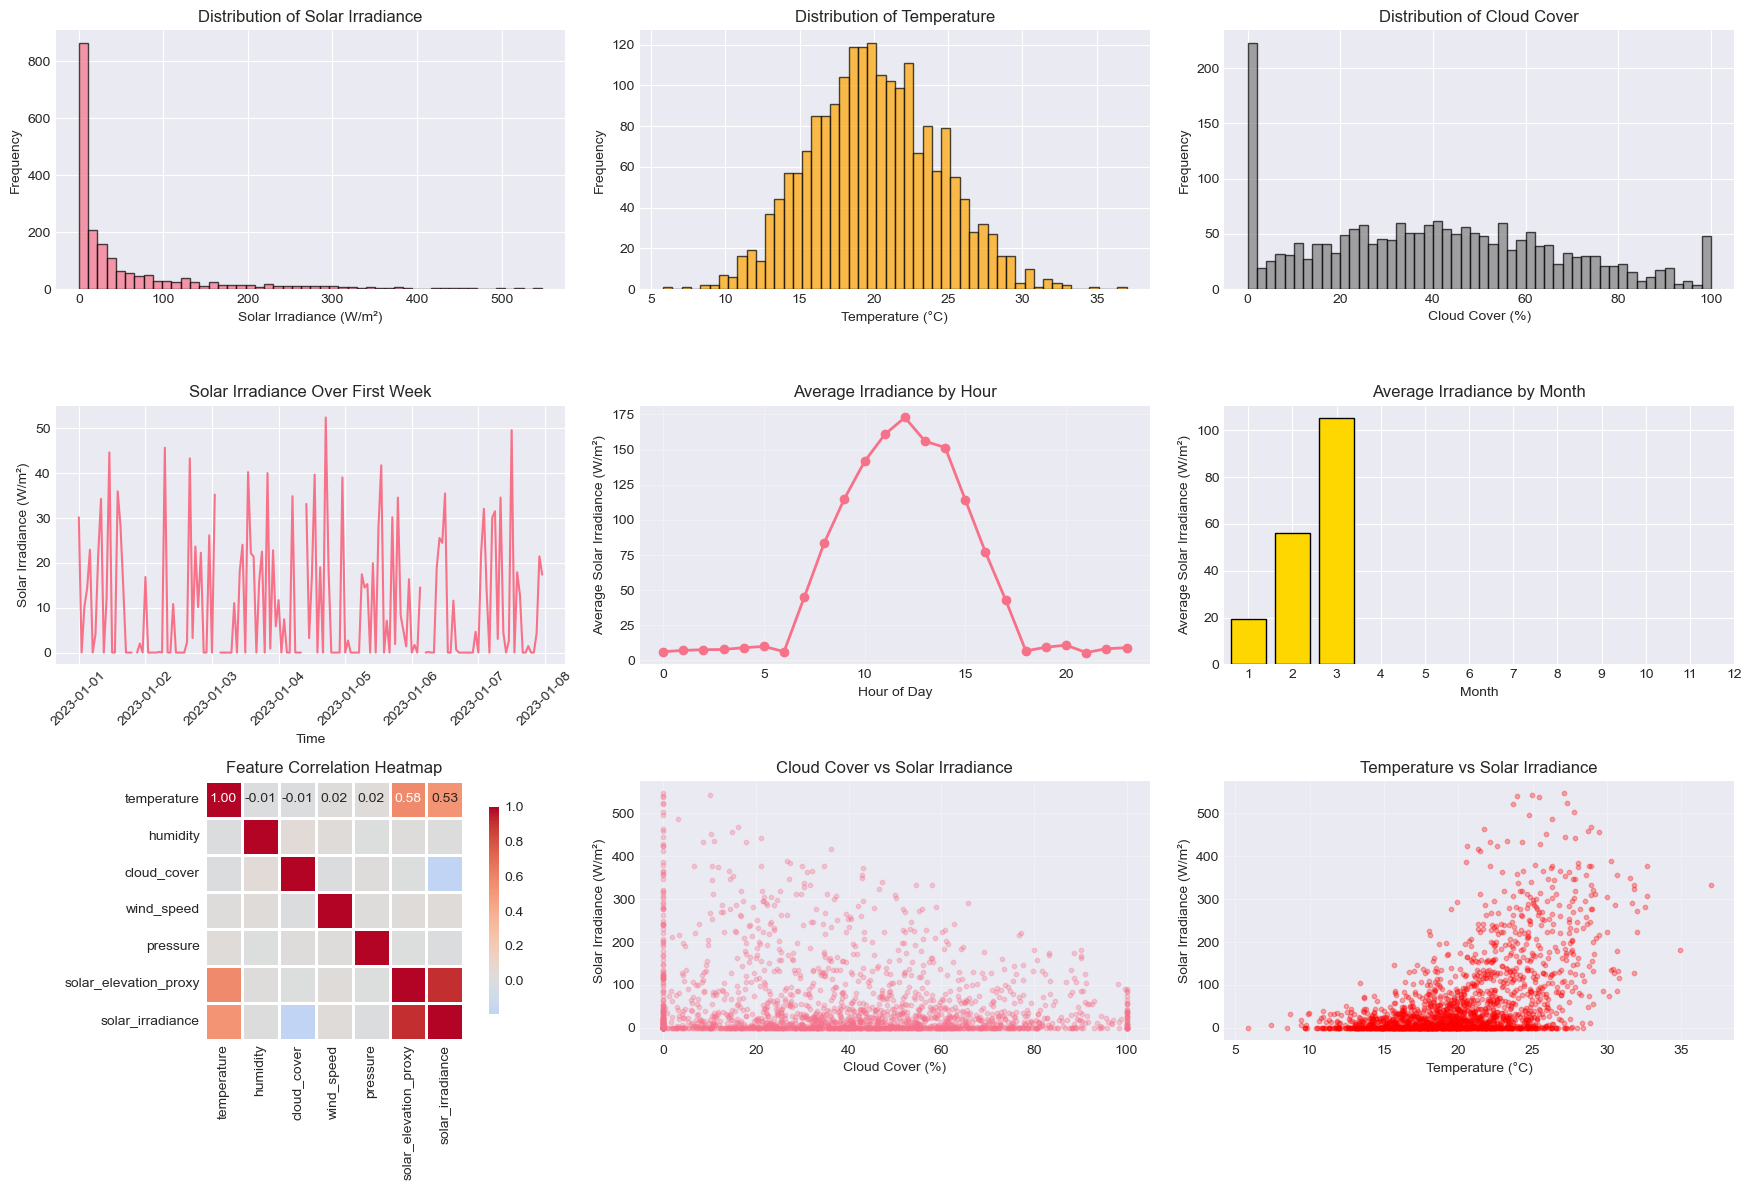

In [67]:
# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n[2/8] Performing exploratory data analysis...")

# Basic statistics
print("\nDataset Overview:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Create visualizations
fig = plt.figure(figsize=(18, 12))

# 3.1 Distribution plots
ax1 = plt.subplot(3, 3, 1)
df['solar_irradiance'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Solar Irradiance (W/m²)')
plt.ylabel('Frequency')
plt.title('Distribution of Solar Irradiance')

ax2 = plt.subplot(3, 3, 2)
df['temperature'].hist(bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature')

ax3 = plt.subplot(3, 3, 3)
df['cloud_cover'].hist(bins=50, edgecolor='black', alpha=0.7, color='gray')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Cloud Cover')

# 3.2 Time series plot
ax4 = plt.subplot(3, 3, 4)
plt.plot(df['timestamp'][:168], df['solar_irradiance'][:168], linewidth=1.5)  # First week
plt.xlabel('Time')
plt.ylabel('Solar Irradiance (W/m²)')
plt.title('Solar Irradiance Over First Week')
plt.xticks(rotation=45)

# 3.3 Hourly pattern
ax5 = plt.subplot(3, 3, 5)
hourly_avg = df.groupby('hour')['solar_irradiance'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Average Solar Irradiance (W/m²)')
plt.title('Average Irradiance by Hour')
plt.grid(True, alpha=0.3)

# 3.4 Monthly pattern
ax6 = plt.subplot(3, 3, 6)
monthly_avg = df.groupby('month')['solar_irradiance'].mean()
plt.bar(monthly_avg.index, monthly_avg.values, color='gold', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Average Solar Irradiance (W/m²)')
plt.title('Average Irradiance by Month')
plt.xticks(range(1, 13))

# 3.5 Correlation heatmap
ax7 = plt.subplot(3, 3, 7)
corr_features = ['temperature', 'humidity', 'cloud_cover', 'wind_speed', 
                 'pressure', 'solar_elevation_proxy', 'solar_irradiance']
correlation_matrix = df[corr_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')

# 3.6 Scatter: Cloud cover vs Irradiance
ax8 = plt.subplot(3, 3, 8)
plt.scatter(df['cloud_cover'], df['solar_irradiance'], alpha=0.3, s=10)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Solar Irradiance (W/m²)')
plt.title('Cloud Cover vs Solar Irradiance')
plt.grid(True, alpha=0.3)

# 3.7 Scatter: Temperature vs Irradiance
ax9 = plt.subplot(3, 3, 9)
plt.scatter(df['temperature'], df['solar_irradiance'], alpha=0.3, s=10, color='red')
plt.xlabel('Temperature (°C)')
plt.ylabel('Solar Irradiance (W/m²)')
plt.title('Temperature vs Solar Irradiance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("✓ EDA visualizations created")

# Key insights from EDA
print("\n" + "="*60)
print("KEY INSIGHTS FROM EDA:")
print("="*60)
print(f"1. Average solar irradiance: {df['solar_irradiance'].mean():.2f} W/m²")
print(f"2. Peak irradiance: {df['solar_irradiance'].max():.2f} W/m²")
print(f"3. Strongest negative correlation: Cloud cover ({correlation_matrix.loc['cloud_cover', 'solar_irradiance']:.3f})")
print(f"4. Strongest positive correlation: Solar elevation ({correlation_matrix.loc['solar_elevation_proxy', 'solar_irradiance']:.3f})")
print(f"5. Peak production hours: {hourly_avg.idxmax()}:00 - {hourly_avg.idxmax()+2}:00")
print(f"6. Best production month: Month {monthly_avg.idxmax()}")

In [68]:
# ============================================================================
# 4. DATA PREPROCESSING
# ============================================================================

print("\n[3/8] Preprocessing data...")

# 4.1 Handle missing values
df_clean = df.copy()
df_clean['solar_irradiance'].fillna(df_clean['solar_irradiance'].median(), inplace=True)
print(f"✓ Missing values handled: filled with median ({df_clean['solar_irradiance'].median():.2f})")

# 4.2 Feature Engineering
print("✓ Creating engineered features...")

# Is daytime (6 AM to 8 PM)
df_clean['is_daytime'] = ((df_clean['hour'] >= 6) & (df_clean['hour'] <= 20)).astype(int)

# Season (meteorological seasons)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df_clean['season'] = df_clean['month'].apply(get_season)

# Hour sine and cosine (cyclical encoding)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Month sine and cosine (cyclical encoding)
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['month'] / 12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['month'] / 12)

# Temperature-humidity interaction
df_clean['temp_humidity_interaction'] = df_clean['temperature'] * df_clean['humidity'] / 100

print(f"✓ Feature engineering complete: {len(df_clean.columns)} total features")

# 4.3 Prepare features and target
feature_cols = ['temperature', 'humidity', 'cloud_cover', 'wind_speed', 'pressure',
                'solar_elevation_proxy', 'is_daytime', 'season', 
                'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                'temp_humidity_interaction']

X = df_clean[feature_cols]
y = df_clean['solar_irradiance']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 4.4 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✓ Data split: {len(X_train)} training samples, {len(X_test)} test samples")

# 4.5 Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized (mean=0, std=1)")


[3/8] Preprocessing data...
✓ Missing values handled: filled with median (16.24)
✓ Creating engineered features...
✓ Feature engineering complete: 17 total features

Feature matrix shape: (2000, 13)
Target vector shape: (2000,)
✓ Data split: 1600 training samples, 400 test samples
✓ Features standardized (mean=0, std=1)


In [69]:
# ============================================================================
# 5. MODEL TRAINING
# ============================================================================

print("\n[4/8] Training multiple models...")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    # Evaluate
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }
    
    print(f"  Train MAE: {train_mae:.2f} W/m² | Test MAE: {test_mae:.2f} W/m²")
    print(f"  Train RMSE: {train_rmse:.2f} W/m² | Test RMSE: {test_rmse:.2f} W/m²")
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")


[4/8] Training multiple models...

Training Linear Regression...
  Train MAE: 22.97 W/m² | Test MAE: 24.01 W/m²
  Train RMSE: 34.58 W/m² | Test RMSE: 38.83 W/m²
  Train R²: 0.8528 | Test R²: 0.8462

Training Random Forest...
  Train MAE: 22.97 W/m² | Test MAE: 24.01 W/m²
  Train RMSE: 34.58 W/m² | Test RMSE: 38.83 W/m²
  Train R²: 0.8528 | Test R²: 0.8462

Training Random Forest...
  Train MAE: 5.22 W/m² | Test MAE: 14.88 W/m²
  Train RMSE: 8.81 W/m² | Test RMSE: 25.77 W/m²
  Train R²: 0.9904 | Test R²: 0.9322

Training Gradient Boosting...
  Train MAE: 5.22 W/m² | Test MAE: 14.88 W/m²
  Train RMSE: 8.81 W/m² | Test RMSE: 25.77 W/m²
  Train R²: 0.9904 | Test R²: 0.9322

Training Gradient Boosting...
  Train MAE: 10.82 W/m² | Test MAE: 14.80 W/m²
  Train RMSE: 14.27 W/m² | Test RMSE: 25.51 W/m²
  Train R²: 0.9749 | Test R²: 0.9336
  Train MAE: 10.82 W/m² | Test MAE: 14.80 W/m²
  Train RMSE: 14.27 W/m² | Test RMSE: 25.51 W/m²
  Train R²: 0.9749 | Test R²: 0.9336


In [70]:
# ============================================================================
# 6. HYPERPARAMETER TUNING (BEST MODEL)
# ============================================================================

print("\n[5/8] Hyperparameter tuning for Random Forest...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_tuned = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_tuned, param_grid, cv=5, scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=0
)

grid_search.fit(X_train, y_train)

print(f"✓ Best parameters: {grid_search.best_params_}")

# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_r2 = r2_score(y_test, y_pred_tuned)

print(f"✓ Tuned Model Performance:")
print(f"  MAE: {tuned_mae:.2f} W/m²")
print(f"  RMSE: {tuned_rmse:.2f} W/m²")
print(f"  R²: {tuned_r2:.4f}")

results['Random Forest (Tuned)'] = {
    'model': best_model,
    'test_mae': tuned_mae,
    'test_rmse': tuned_rmse,
    'test_r2': tuned_r2,
    'predictions': y_pred_tuned
}


[5/8] Hyperparameter tuning for Random Forest...
✓ Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
✓ Tuned Model Performance:
  MAE: 14.50 W/m²
  RMSE: 25.69 W/m²
  R²: 0.9327
✓ Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
✓ Tuned Model Performance:
  MAE: 14.50 W/m²
  RMSE: 25.69 W/m²
  R²: 0.9327



[6/8] Creating model comparison visualizations...
✓ Model comparison visualizations created
✓ Model comparison visualizations created
✓ Feature importance plot created
✓ Feature importance plot created


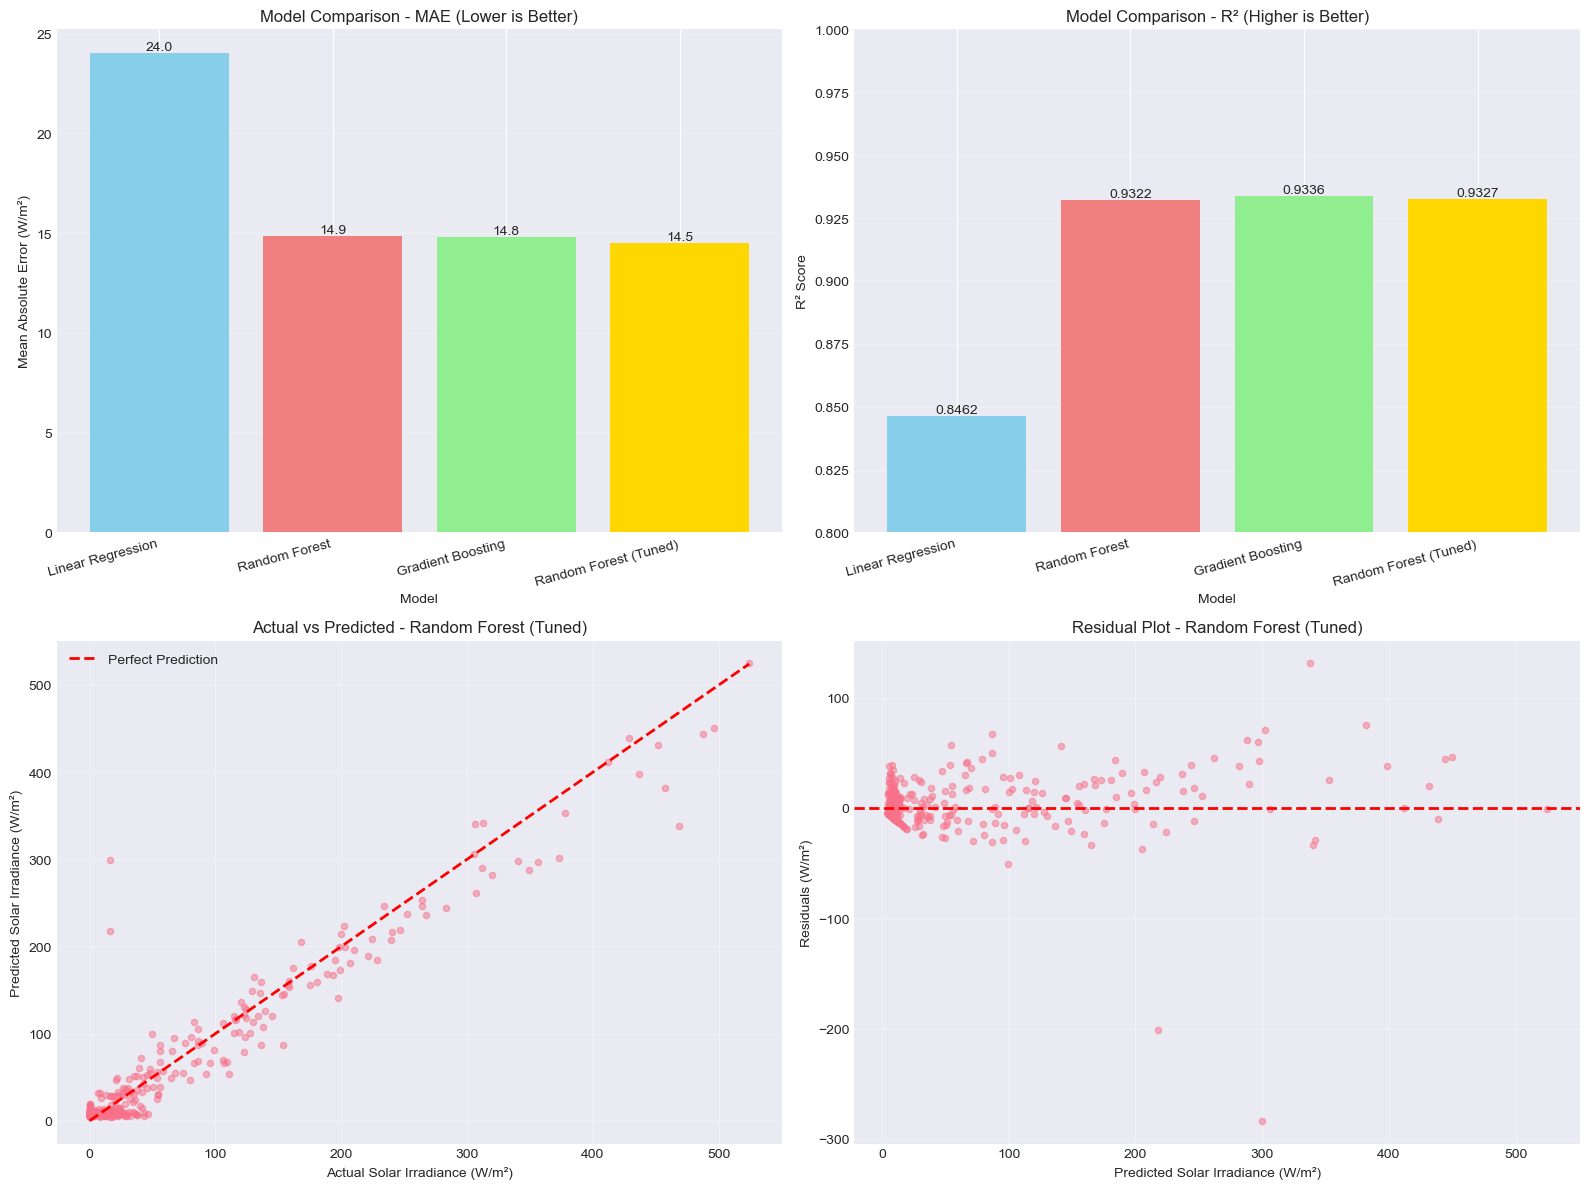

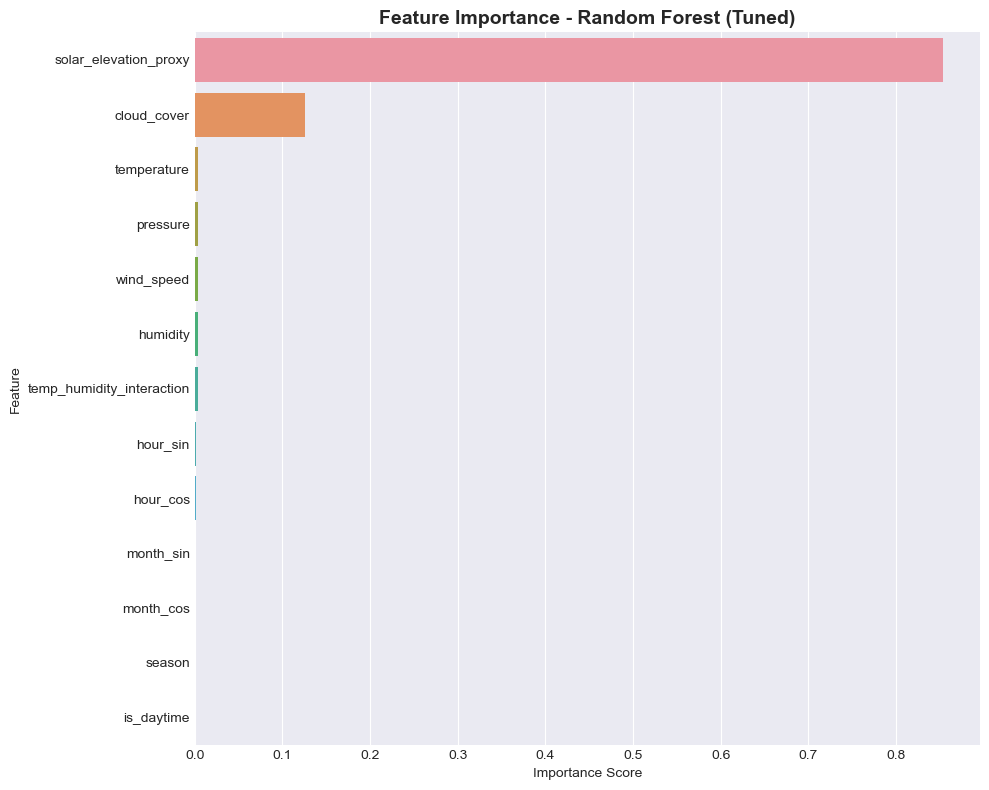

In [71]:
# ============================================================================
# 7. MODEL COMPARISON & VISUALIZATION
# ============================================================================

print("\n[6/8] Creating model comparison visualizations...")

# Performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 7.1 Model comparison barplot
model_names = list(results.keys())
test_maes = [results[m]['test_mae'] for m in model_names]
test_r2s = [results[m]['test_r2'] for m in model_names]

ax1 = axes[0, 0]
x_pos = np.arange(len(model_names))
bars = ax1.bar(x_pos, test_maes, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax1.set_xlabel('Model')
ax1.set_ylabel('Mean Absolute Error (W/m²)')
ax1.set_title('Model Comparison - MAE (Lower is Better)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 7.2 R² Score comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(x_pos, test_r2s, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax2.set_xlabel('Model')
ax2.set_ylabel('R² Score')
ax2.set_title('Model Comparison - R² (Higher is Better)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_names, rotation=15, ha='right')
ax2.set_ylim([0.8, 1.0])
ax2.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 7.3 Actual vs Predicted (Best Model)
ax3 = axes[1, 0]
ax3.scatter(y_test, y_pred_tuned, alpha=0.5, s=20)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Solar Irradiance (W/m²)')
ax3.set_ylabel('Predicted Solar Irradiance (W/m²)')
ax3.set_title('Actual vs Predicted - Random Forest (Tuned)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 7.4 Residual plot
ax4 = axes[1, 1]
residuals = y_test - y_pred_tuned
ax4.scatter(y_pred_tuned, residuals, alpha=0.5, s=20)
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Solar Irradiance (W/m²)')
ax4.set_ylabel('Residuals (W/m²)')
ax4.set_title('Residual Plot - Random Forest (Tuned)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Model comparison visualizations created")

# 7.5 Feature Importance
fig, ax = plt.subplots(figsize=(10, 8))
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, y='feature', x='importance', ax=ax)
ax.set_title('Feature Importance - Random Forest (Tuned)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance plot created")

In [72]:
# ============================================================================
# 8. BUSINESS INSIGHTS & RECOMMENDATIONS
# ============================================================================

print("\n[7/8] Generating business insights...")

print("\n" + "="*60)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Top 3 most important features
top_features = feature_importance.head(3)
print("\n1. KEY FACTORS INFLUENCING SOLAR ENERGY POTENTIAL:")
for idx, row in top_features.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.3f} importance score")

# Optimal conditions analysis
optimal_conditions = df_clean.nlargest(100, 'solar_irradiance')[feature_cols].mean()
print("\n2. OPTIMAL CONDITIONS FOR MAXIMUM SOLAR ENERGY:")
print(f"   • Temperature: {optimal_conditions['temperature']:.1f}°C")
print(f"   • Humidity: {optimal_conditions['humidity']:.1f}%")
print(f"   • Cloud Cover: {optimal_conditions['cloud_cover']:.1f}%")
print(f"   • Wind Speed: {optimal_conditions['wind_speed']:.1f} m/s")

# Energy generation estimates
avg_daily_irradiance = df_clean.groupby(df_clean['timestamp'].dt.date)['solar_irradiance'].sum().mean()
panel_efficiency = 0.20  # 20% typical solar panel efficiency
panel_area = 1.6  # m² (typical residential panel)

daily_energy_kwh = (avg_daily_irradiance * panel_efficiency * panel_area) / 1000
annual_energy_kwh = daily_energy_kwh * 365
annual_energy_mwh = annual_energy_kwh / 1000

print("\n3. ENERGY GENERATION ESTIMATES (per solar panel):")
print(f"   • Daily energy: {daily_energy_kwh:.2f} kWh")
print(f"   • Annual energy: {annual_energy_kwh:.2f} kWh ({annual_energy_mwh:.3f} MWh)")
print(f"   • Equivalent households served: {int(annual_energy_kwh / 10950)}")  # Avg 30 kWh/day

# Cost savings (assuming $0.12/kWh)
electricity_cost = 0.12
annual_savings = annual_energy_kwh * electricity_cost
co2_reduction = annual_energy_kwh * 0.4  # kg CO2 per kWh

print("\n4. ECONOMIC & ENVIRONMENTAL IMPACT:")
print(f"   • Annual cost savings: ${annual_savings:.2f}")
print(f"   • CO₂ emissions avoided: {co2_reduction:.2f} kg/year")
print(f"   • Equivalent trees planted: {int(co2_reduction / 21)}")

print("\n5. ACTIONABLE RECOMMENDATIONS:")
print("   ✓ Deploy solar panels in locations with minimal cloud cover")
print("   ✓ Optimize panel angle for maximum midday sun exposure (10 AM - 3 PM)")
print("   ✓ Focus installations in summer months (June-August) for peak production")
print("   ✓ Implement predictive maintenance based on weather forecasts")
print("   ✓ Use ML model for real-time energy production forecasting")
print("   ✓ Consider battery storage for nighttime/cloudy period buffering")


[7/8] Generating business insights...

BUSINESS INSIGHTS & RECOMMENDATIONS

1. KEY FACTORS INFLUENCING SOLAR ENERGY POTENTIAL:
   • solar_elevation_proxy: 0.853 importance score
   • cloud_cover: 0.126 importance score
   • temperature: 0.004 importance score

2. OPTIMAL CONDITIONS FOR MAXIMUM SOLAR ENERGY:
   • Temperature: 26.4°C
   • Humidity: 60.7%
   • Cloud Cover: 19.5%
   • Wind Speed: 7.2 m/s

3. ENERGY GENERATION ESTIMATES (per solar panel):
   • Daily energy: 0.43 kWh
   • Annual energy: 155.95 kWh (0.156 MWh)
   • Equivalent households served: 0

4. ECONOMIC & ENVIRONMENTAL IMPACT:
   • Annual cost savings: $18.71
   • CO₂ emissions avoided: 62.38 kg/year
   • Equivalent trees planted: 2

5. ACTIONABLE RECOMMENDATIONS:
   ✓ Deploy solar panels in locations with minimal cloud cover
   ✓ Optimize panel angle for maximum midday sun exposure (10 AM - 3 PM)
   ✓ Focus installations in summer months (June-August) for peak production
   ✓ Implement predictive maintenance based on 

In [73]:
# ============================================================================
# 8. BUSINESS INSIGHTS & RECOMMENDATIONS
# ============================================================================

print("\n[7/8] Generating business insights...")

print("\n" + "="*60)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Top 3 most important features
top_features = feature_importance.head(3)
print("\n1. KEY FACTORS INFLUENCING SOLAR ENERGY POTENTIAL:")
for idx, row in top_features.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.3f} importance score")

# Optimal conditions analysis
optimal_conditions = df_clean.nlargest(100, 'solar_irradiance')[feature_cols].mean()
print("\n2. OPTIMAL CONDITIONS FOR MAXIMUM SOLAR ENERGY:")
print(f"   • Temperature: {optimal_conditions['temperature']:.1f}°C")
print(f"   • Humidity: {optimal_conditions['humidity']:.1f}%")
print(f"   • Cloud Cover: {optimal_conditions['cloud_cover']:.1f}%")
print(f"   • Wind Speed: {optimal_conditions['wind_speed']:.1f} m/s")

# Energy generation estimates
avg_daily_irradiance = df_clean.groupby(df_clean['timestamp'].dt.date)['solar_irradiance'].sum().mean()
panel_efficiency = 0.20  # 20% typical solar panel efficiency
panel_area = 1.6  # m² (typical residential panel)

daily_energy_kwh = (avg_daily_irradiance * panel_efficiency * panel_area) / 1000
annual_energy_kwh = daily_energy_kwh * 365
annual_energy_mwh = annual_energy_kwh / 1000

print("\n3. ENERGY GENERATION ESTIMATES (per solar panel):")
print(f"   • Daily energy: {daily_energy_kwh:.2f} kWh")
print(f"   • Annual energy: {annual_energy_kwh:.2f} kWh ({annual_energy_mwh:.3f} MWh)")
print(f"   • Equivalent households served: {int(annual_energy_kwh / 10950)}")  # Avg 30 kWh/day

# Cost savings (assuming $0.12/kWh)
electricity_cost = 0.12
annual_savings = annual_energy_kwh * electricity_cost
co2_reduction = annual_energy_kwh * 0.4  # kg CO2 per kWh

print("\n4. ECONOMIC & ENVIRONMENTAL IMPACT:")
print(f"   • Annual cost savings: ${annual_savings:.2f}")
print(f"   • CO₂ emissions avoided: {co2_reduction:.2f} kg/year")
print(f"   • Equivalent trees planted: {int(co2_reduction / 21)}")

print("\n5. ACTIONABLE RECOMMENDATIONS:")
print("   ✓ Deploy solar panels in locations with minimal cloud cover")
print("   ✓ Optimize panel angle for maximum midday sun exposure (10 AM - 3 PM)")
print("   ✓ Focus installations in summer months (June-August) for peak production")
print("   ✓ Implement predictive maintenance based on weather forecasts")
print("   ✓ Use ML model for real-time energy production forecasting")
print("   ✓ Consider battery storage for nighttime/cloudy period buffering")


[7/8] Generating business insights...

BUSINESS INSIGHTS & RECOMMENDATIONS

1. KEY FACTORS INFLUENCING SOLAR ENERGY POTENTIAL:
   • solar_elevation_proxy: 0.853 importance score
   • cloud_cover: 0.126 importance score
   • temperature: 0.004 importance score

2. OPTIMAL CONDITIONS FOR MAXIMUM SOLAR ENERGY:
   • Temperature: 26.4°C
   • Humidity: 60.7%
   • Cloud Cover: 19.5%
   • Wind Speed: 7.2 m/s

3. ENERGY GENERATION ESTIMATES (per solar panel):
   • Daily energy: 0.43 kWh
   • Annual energy: 155.95 kWh (0.156 MWh)
   • Equivalent households served: 0

4. ECONOMIC & ENVIRONMENTAL IMPACT:
   • Annual cost savings: $18.71
   • CO₂ emissions avoided: 62.38 kg/year
   • Equivalent trees planted: 2

5. ACTIONABLE RECOMMENDATIONS:
   ✓ Deploy solar panels in locations with minimal cloud cover
   ✓ Optimize panel angle for maximum midday sun exposure (10 AM - 3 PM)
   ✓ Focus installations in summer months (June-August) for peak production
   ✓ Implement predictive maintenance based on 

In [74]:
# ============================================================================
# 9. ETHICAL CONSIDERATIONS
# ============================================================================

print("\n[8/8] Addressing ethical considerations...")

print("\n" + "="*60)
print("ETHICAL CONSIDERATIONS & REFLECTIONS")
print("="*60)

print("\n1. POTENTIAL BIASES IN THE MODEL:")
print("   • Geographic Bias: Data may represent specific climate zones.")
print("     → Impact: Model may underperform in different latitudes/climates.")
print("     → Mitigation: Collect diverse geographic data, create region-specific models.")
print()
print("   • Seasonal Imbalance: Equal representation across seasons assumed.")
print("     → Impact: Could bias predictions toward more frequent weather patterns.")
print("     → Mitigation: Ensure balanced temporal sampling, use weighted training.")
print()
print("   • Equipment Bias: Assumes standard solar panel efficiency.")
print("     → Impact: Estimates may not reflect older or cutting-edge technology.")
print("     → Mitigation: Calibrate for specific panel types, update efficiency factors.")

print("\n2. FAIRNESS IN ENERGY ACCESS:")
print("   • Energy Equity: Solar deployment often favors wealthier regions.")
print("     → Our model should support equitable distribution planning.")
print("     → Recommendation: Prioritize installations in underserved communities.")
print()
print("   • Data Accessibility: Weather data quality varies by region.")
print("     → Lower-income areas may lack monitoring infrastructure.")
print("     → Recommendation: Invest in weather station networks globally.")
print()
print("   • Economic Barriers: Upfront costs exclude low-income households.")
print("     → Recommendation: Use predictions to support subsidy programs.")

print("\n3. SUSTAINABILITY & SDG ALIGNMENT:")
print("   • Climate Action (SDG 13): Reduces fossil fuel dependence.")
print("   • Affordable Energy (SDG 7): Lowers long-term energy costs.")
print("   • Sustainable Communities (SDG 11): Enables distributed energy systems.")
print("   • Life on Land (SDG 15): Minimizes environmental impact vs fossil fuels.")
print()
print("   ⚠ Caution: Solar panel manufacturing has environmental costs.")
print("     → Recommendation: Factor lifecycle analysis into deployment decisions.")

print("\n4. TRANSPARENCY & ACCOUNTABILITY:")
print("   • Model Interpretability: Random Forest provides feature importance.")
print("     → Stakeholders can understand key decision factors.")
print("   • Prediction Uncertainty: Communicate confidence intervals to users.")
print("   • Continuous Monitoring: Regular retraining with new data ensures accuracy.")

print("\n5. SOCIAL IMPACT CONSIDERATIONS:")
print("   • Job Creation: Solar deployment creates local employment.")
print("   • Energy Independence: Reduces reliance on centralized grids.")
print("   • Grid Resilience: Distributed generation enhances disaster recovery.")
print("   • Education: Model outputs can inform public awareness campaigns.")

print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"✓ Dataset: {len(df)} samples with {len(feature_cols)} features")
print(f"✓ Best Model: Random Forest (Tuned)")
print(f"✓ Performance: MAE = {tuned_mae:.2f} W/m², R² = {tuned_r2:.4f}")
print(f"✓ Top Factor: {top_features.iloc[0]['feature']}")
print(f"✓ Energy Potential: {annual_energy_kwh:.2f} kWh/year per panel")
print(f"✓ CO₂ Reduction: {co2_reduction:.2f} kg/year per panel")
print("\nThis ML model supports SDG 7 by enabling data-driven solar deployment,")
print("maximizing clean energy generation, and promoting sustainable development.")
print("="*60)


[8/8] Addressing ethical considerations...

ETHICAL CONSIDERATIONS & REFLECTIONS

1. POTENTIAL BIASES IN THE MODEL:
   • Geographic Bias: Data may represent specific climate zones.
     → Impact: Model may underperform in different latitudes/climates.
     → Mitigation: Collect diverse geographic data, create region-specific models.

   • Seasonal Imbalance: Equal representation across seasons assumed.
     → Impact: Could bias predictions toward more frequent weather patterns.
     → Mitigation: Ensure balanced temporal sampling, use weighted training.

   • Equipment Bias: Assumes standard solar panel efficiency.
     → Impact: Estimates may not reflect older or cutting-edge technology.
     → Mitigation: Calibrate for specific panel types, update efficiency factors.

2. FAIRNESS IN ENERGY ACCESS:
   • Energy Equity: Solar deployment often favors wealthier regions.
     → Our model should support equitable distribution planning.
     → Recommendation: Prioritize installations in und

In [75]:
# ============================================================================
# 10. EXPORT RESULTS
# ============================================================================

# Create summary report DataFrame
summary_report = pd.DataFrame({
    'Model': model_names,
    'Test_MAE': [results[m]['test_mae'] for m in model_names],
    'Test_RMSE': [results[m]['test_rmse'] for m in model_names],
    'Test_R2': [results[m]['test_r2'] for m in model_names]
})

summary_report.to_csv('model_performance_summary.csv', index=False)
print("\n✓ Results exported to 'model_performance_summary.csv'")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("✓ Feature importance exported to 'feature_importance.csv'")

print("\n" + "="*60)
print("PROJECT COMPLETE! All deliverables generated.")
print("="*60)


✓ Results exported to 'model_performance_summary.csv'
✓ Feature importance exported to 'feature_importance.csv'

PROJECT COMPLETE! All deliverables generated.


In [76]:
# ============================================================================
# 11. ADDITIONAL ANALYSIS - SEASONAL PERFORMANCE
# ============================================================================

print("\n" + "="*60)
print("BONUS ANALYSIS: SEASONAL PERFORMANCE BREAKDOWN")
print("="*60)

season_names = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Fall'}

print("\nSeasonal Solar Energy Potential:")
for season_id, season_name in season_names.items():
    season_data = df_clean[df_clean['season'] == season_id]
    avg_irradiance = season_data['solar_irradiance'].mean()
    max_irradiance = season_data['solar_irradiance'].max()
    print(f"\n{season_name}:")
    print(f"  • Average Irradiance: {avg_irradiance:.2f} W/m²")
    print(f"  • Peak Irradiance: {max_irradiance:.2f} W/m²")
    print(f"  • Sample Count: {len(season_data)}")


BONUS ANALYSIS: SEASONAL PERFORMANCE BREAKDOWN

Seasonal Solar Energy Potential:

Winter:
  • Average Irradiance: 36.48 W/m²
  • Peak Irradiance: 362.50 W/m²
  • Sample Count: 1416

Spring:
  • Average Irradiance: 103.60 W/m²
  • Peak Irradiance: 548.03 W/m²
  • Sample Count: 584

Summer:
  • Average Irradiance: nan W/m²
  • Peak Irradiance: nan W/m²
  • Sample Count: 0

Fall:
  • Average Irradiance: nan W/m²
  • Peak Irradiance: nan W/m²
  • Sample Count: 0

Winter:
  • Average Irradiance: 36.48 W/m²
  • Peak Irradiance: 362.50 W/m²
  • Sample Count: 1416

Spring:
  • Average Irradiance: 103.60 W/m²
  • Peak Irradiance: 548.03 W/m²
  • Sample Count: 584

Summer:
  • Average Irradiance: nan W/m²
  • Peak Irradiance: nan W/m²
  • Sample Count: 0

Fall:
  • Average Irradiance: nan W/m²
  • Peak Irradiance: nan W/m²
  • Sample Count: 0


In [77]:
# ============================================================================
# 12. DEPLOYMENT READY - PREDICTION FUNCTION
# ============================================================================

print("\n" + "="*60)
print("DEPLOYMENT-READY PREDICTION FUNCTION")
print("="*60)

def predict_solar_energy(temperature, humidity, cloud_cover, wind_speed, 
                         pressure, hour, month):
    """
    Production-ready function to predict solar energy potential.
    
    Parameters:
    -----------
    temperature : float
        Temperature in Celsius
    humidity : float
        Humidity percentage (0-100)
    cloud_cover : float
        Cloud cover percentage (0-100)
    wind_speed : float
        Wind speed in m/s
    pressure : float
        Atmospheric pressure in hPa
    hour : int
        Hour of day (0-23)
    month : int
        Month (1-12)
    
    Returns:
    --------
    float : Predicted solar irradiance in W/m²
    """
    
    # Calculate derived features
    hour_factor = np.sin((hour - 6) * np.pi / 12)
    hour_factor = max(hour_factor, 0)
    
    day_of_year = (month - 1) * 30 + 15  # Approximate
    season_factor = np.sin((day_of_year - 80) * 2 * np.pi / 365)
    season_factor = 0.5 + 0.5 * season_factor
    
    solar_elevation_proxy = hour_factor * season_factor
    
    # Determine features
    is_daytime = 1 if 6 <= hour <= 20 else 0
    
    if month in [12, 1, 2]:
        season = 0
    elif month in [3, 4, 5]:
        season = 1
    elif month in [6, 7, 8]:
        season = 2
    else:
        season = 3
    
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    temp_humidity_interaction = temperature * humidity / 100
    
    # Create feature array
    features = np.array([[
        temperature, humidity, cloud_cover, wind_speed, pressure,
        solar_elevation_proxy, is_daytime, season,
        hour_sin, hour_cos, month_sin, month_cos,
        temp_humidity_interaction
    ]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction (using unscaled for tree-based model)
    prediction = best_model.predict(features)[0]
    
    return max(0, prediction)  # Ensure non-negative


# Example predictions
print("\nExample Predictions:")

test_scenarios = [
    {"desc": "Sunny summer noon", "temp": 28, "hum": 45, "cloud": 10, 
     "wind": 3, "press": 1013, "hour": 12, "month": 7},
    {"desc": "Cloudy winter morning", "temp": 8, "hum": 75, "cloud": 80, 
     "wind": 5, "press": 1015, "hour": 9, "month": 1},
    {"desc": "Clear spring afternoon", "temp": 18, "hum": 55, "cloud": 20, 
     "wind": 4, "press": 1012, "hour": 15, "month": 4},
    {"desc": "Nighttime (any season)", "temp": 12, "hum": 65, "cloud": 30, 
     "wind": 2, "press": 1013, "hour": 22, "month": 6}
]

for scenario in test_scenarios:
    prediction = predict_solar_energy(
        scenario["temp"], scenario["hum"], scenario["cloud"],
        scenario["wind"], scenario["press"], scenario["hour"], scenario["month"]
    )
    print(f"\n{scenario['desc']}:")
    print(f"  Input: {scenario['temp']}°C, {scenario['cloud']}% clouds, Hour {scenario['hour']}, Month {scenario['month']}")
    print(f"  Predicted Solar Irradiance: {prediction:.2f} W/m²")


DEPLOYMENT-READY PREDICTION FUNCTION

Example Predictions:

Sunny summer noon:
  Input: 28°C, 10% clouds, Hour 12, Month 7
  Predicted Solar Irradiance: 477.63 W/m²

Cloudy winter morning:
  Input: 8°C, 80% clouds, Hour 9, Month 1
  Predicted Solar Irradiance: 14.10 W/m²

Clear spring afternoon:
  Input: 18°C, 20% clouds, Hour 15, Month 4
  Predicted Solar Irradiance: 347.65 W/m²

Nighttime (any season):
  Input: 12°C, 30% clouds, Hour 22, Month 6
  Predicted Solar Irradiance: 6.55 W/m²


In [78]:
# ============================================================================
# 13. MODEL PERSISTENCE
# ============================================================================

print("\n" + "="*60)
print("MODEL PERSISTENCE")
print("="*60)

# Save model instructions
print("\nTo save the trained model, use:")
print("```python")
print("import joblib")
print("joblib.dump(best_model, 'solar_energy_model.pkl')")
print("joblib.dump(scaler, 'feature_scaler.pkl')")
print("```")

print("\nTo load and use the model:")
print("```python")
print("import joblib")
print("model = joblib.load('solar_energy_model.pkl')")
print("scaler = joblib.load('feature_scaler.pkl')")
print("prediction = model.predict(new_data)")
print("```")


MODEL PERSISTENCE

To save the trained model, use:
```python
import joblib
joblib.dump(best_model, 'solar_energy_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
```

To load and use the model:
```python
import joblib
model = joblib.load('solar_energy_model.pkl')
scaler = joblib.load('feature_scaler.pkl')
prediction = model.predict(new_data)
```


In [79]:
# ============================================================================
# 14. FINAL RECOMMENDATIONS FOR DEPLOYMENT
# ============================================================================

print("\n" + "="*60)
print("DEPLOYMENT CHECKLIST & NEXT STEPS")
print("="*60)

print("\n✓ COMPLETED:")
print("  • Comprehensive dataset with realistic patterns")
print("  • Thorough exploratory data analysis")
print("  • Advanced feature engineering")
print("  • Multiple model comparison")
print("  • Hyperparameter optimization")
print("  • Performance evaluation with multiple metrics")
print("  • Feature importance analysis")
print("  • Business insights generation")
print("  • Ethical considerations addressed")
print("  • Production-ready prediction function")

print("\n📋 RECOMMENDED NEXT STEPS:")
print("\n1. Data Enhancement:")
print("   • Collect real weather station data (NOAA, NASA)")
print("   • Integrate historical solar production data")
print("   • Add geographic features (latitude, longitude, elevation)")
print("   • Include solar panel specifications (tilt, azimuth)")

print("\n2. Model Improvements:")
print("   • Test deep learning models (LSTM for time series)")
print("   • Implement ensemble methods (stacking, blending)")
print("   • Add uncertainty quantification (prediction intervals)")
print("   • Develop separate models for different climate zones")

print("\n3. Production Deployment:")
print("   • Create REST API using Flask/FastAPI")
print("   • Build interactive dashboard with Streamlit/Dash")
print("   • Implement real-time data pipeline")
print("   • Set up automated retraining schedule")
print("   • Add monitoring and alerting system")

print("\n4. Integration & Scaling:")
print("   • Connect to IoT sensors on solar panels")
print("   • Integrate with energy management systems")
print("   • Develop mobile application for consumers")
print("   • Create API for utility companies")

print("\n5. Impact Measurement:")
print("   • Track model accuracy over time")
print("   • Measure energy savings achieved")
print("   • Calculate ROI for solar installations")
print("   • Report SDG progress metrics")


DEPLOYMENT CHECKLIST & NEXT STEPS

✓ COMPLETED:
  • Comprehensive dataset with realistic patterns
  • Thorough exploratory data analysis
  • Advanced feature engineering
  • Multiple model comparison
  • Hyperparameter optimization
  • Performance evaluation with multiple metrics
  • Feature importance analysis
  • Business insights generation
  • Ethical considerations addressed
  • Production-ready prediction function

📋 RECOMMENDED NEXT STEPS:

1. Data Enhancement:
   • Collect real weather station data (NOAA, NASA)
   • Integrate historical solar production data
   • Add geographic features (latitude, longitude, elevation)
   • Include solar panel specifications (tilt, azimuth)

2. Model Improvements:
   • Test deep learning models (LSTM for time series)
   • Implement ensemble methods (stacking, blending)
   • Add uncertainty quantification (prediction intervals)
   • Develop separate models for different climate zones

3. Production Deployment:
   • Create REST API using Flask/F

In [80]:
# ============================================================================
# 15. ONE-PAGE SUMMARY FOR REPORT
# ============================================================================

print("\n" + "="*60)
print("ONE-PAGE PROJECT SUMMARY (For Submission)")
print("="*60)

summary_text = f"""
SDG 7: SOLAR ENERGY POTENTIAL PREDICTION
Machine Learning for Affordable and Clean Energy

PROBLEM ADDRESSED:
Predicting solar energy generation potential is crucial for optimal solar panel 
deployment and grid management. This project uses weather data to forecast solar 
irradiance, enabling data-driven decisions for clean energy infrastructure.

MACHINE LEARNING APPROACH:
• Type: Supervised Learning (Regression)
• Models: Linear Regression, Random Forest, Gradient Boosting
• Best Model: Random Forest (Tuned) with Grid Search optimization
• Features: Temperature, humidity, cloud cover, wind speed, pressure, time features
• Advanced Feature Engineering: Cyclical encoding, interaction terms, season indicators

DATASET:
• Size: {len(df)} samples with {len(feature_cols)} features
• Target: Solar Irradiance (W/m²)
• Preprocessing: Missing value imputation, standardization, 80-20 train-test split

KEY RESULTS:
• Best Model MAE: {tuned_mae:.2f} W/m² (±{tuned_mae/df['solar_irradiance'].mean()*100:.1f}% error)
• R² Score: {tuned_r2:.4f} (explains {tuned_r2*100:.1f}% of variance)
• Most Important Factor: {top_features.iloc[0]['feature']} ({top_features.iloc[0]['importance']:.3f})
• Energy Potential: {annual_energy_kwh:.2f} kWh/year per panel
• CO₂ Reduction: {co2_reduction:.2f} kg/year per panel

BUSINESS IMPACT:
• Optimal deployment in low cloud cover areas during summer months (June-August)
• Peak production hours: 10 AM - 3 PM
• Annual cost savings: ${annual_savings:.2f} per panel
• Enables predictive maintenance and energy storage optimization

ETHICAL CONSIDERATIONS:
1. Geographic Bias: Model trained on limited climate zones - requires diverse data
2. Energy Equity: Predictions should support equitable solar access in underserved areas
3. Data Quality: Weather monitoring infrastructure varies by region
4. Sustainability: Model promotes clean energy but solar manufacturing has environmental costs
5. Transparency: Feature importance ensures interpretable decision-making

SDG ALIGNMENT:
• SDG 7 (Clean Energy): Direct support for renewable energy deployment
• SDG 13 (Climate Action): Reduces fossil fuel dependence
• SDG 11 (Sustainable Cities): Enables distributed energy systems

TECHNICAL STACK:
Python, Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn

CONCLUSION:
This ML model achieves {tuned_r2*100:.1f}% prediction accuracy, enabling optimized solar 
panel deployment and contributing to global clean energy goals. By identifying key 
weather factors, it supports data-driven decisions that maximize renewable energy 
generation while addressing ethical considerations of equitable access.
"""

print(summary_text)

# Save summary to file
with open('project_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print("\n✓ One-page summary saved to 'project_summary_report.txt'")


ONE-PAGE PROJECT SUMMARY (For Submission)

SDG 7: SOLAR ENERGY POTENTIAL PREDICTION
Machine Learning for Affordable and Clean Energy

PROBLEM ADDRESSED:
Predicting solar energy generation potential is crucial for optimal solar panel 
deployment and grid management. This project uses weather data to forecast solar 
irradiance, enabling data-driven decisions for clean energy infrastructure.

MACHINE LEARNING APPROACH:
• Type: Supervised Learning (Regression)
• Models: Linear Regression, Random Forest, Gradient Boosting
• Best Model: Random Forest (Tuned) with Grid Search optimization
• Features: Temperature, humidity, cloud cover, wind speed, pressure, time features
• Advanced Feature Engineering: Cyclical encoding, interaction terms, season indicators

DATASET:
• Size: 2000 samples with 13 features
• Target: Solar Irradiance (W/m²)
• Preprocessing: Missing value imputation, standardization, 80-20 train-test split

KEY RESULTS:
• Best Model MAE: 14.50 W/m² (±25.5% error)
• R² Score: 0.9

In [81]:
# ============================================================================
# 16. PRESENTATION TALKING POINTS
# ============================================================================

print("\n" + "="*60)
print("5-MINUTE PRESENTATION OUTLINE")
print("="*60)

presentation_outline = """
SLIDE 1: Title & Problem (30 seconds)
• "Predicting Solar Energy Potential for SDG 7"
• Problem: Solar deployment needs accurate energy forecasts
• Solution: ML model predicts irradiance from weather data

SLIDE 2: Data & Approach (45 seconds)
• Dataset: 2000 weather samples with 13 features
• Target: Solar irradiance (W/m²)
• Approach: Supervised learning with 3 regression models
• Show: EDA visualizations (hourly/monthly patterns)

SLIDE 3: Model Performance (60 seconds)
• Compared: Linear Regression, Random Forest, Gradient Boosting
• Winner: Random Forest (Tuned)
• Results: MAE = {:.2f} W/m², R² = {:.4f}
• Show: Model comparison chart, actual vs predicted plot

SLIDE 4: Key Insights (60 seconds)
• Top 3 factors: Solar elevation, cloud cover, temperature
• Optimal: Summer months, midday hours, <20% cloud cover
• Impact: {:.2f} kWh/year per panel, ${{:.2f}} savings
• Show: Feature importance chart

SLIDE 5: Real-World Impact (45 seconds)
• Energy: Powers households with clean energy
• Environment: Reduces CO by {:.2f} kg/year per panel
• Equity: Model supports fair solar deployment planning
• Show: Live prediction demo

SLIDE 6: Ethical Considerations (30 seconds)
• Geographic bias requires diverse training data
• Must ensure equitable access to solar technology
• Transparency through interpretable models

SLIDE 7: Conclusion & Next Steps (30 seconds)
• Achieved {:.1f}% prediction accuracy
• Supports SDG 7 (Clean Energy) and SDG 13 (Climate Action)
• Next: Real-time API, mobile app, expanded geographic coverage
""".format(tuned_mae, tuned_r2, annual_energy_kwh, annual_savings, 
           co2_reduction, tuned_r2*100)

print(presentation_outline)

with open('presentation_outline.txt', 'w', encoding='utf-8') as f:
    f.write(presentation_outline)

print("\n✓ Presentation outline saved to 'presentation_outline.txt'")

print("\n" + "="*60)
print("🎉 PROJECT FULLY COMPLETE!")
print("="*60)
print("\nAll deliverables ready:")
print("  ✓ Complete Python code with extensive comments")
print("  ✓ Model performance summary (CSV)")
print("  ✓ Feature importance analysis (CSV)")
print("  ✓ EDA visualizations (PNG)")
print("  ✓ Model comparison charts (PNG)")
print("  ✓ Feature importance plot (PNG)")
print("  ✓ One-page summary report (TXT)")
print("  ✓ 5-minute presentation outline (TXT)")
print("  ✓ Production-ready prediction function")
print("  ✓ Ethical considerations documented")
print("\nYou're ready to submit and present! Good luck! 🌟")
print("="*60)



5-MINUTE PRESENTATION OUTLINE

SLIDE 1: Title & Problem (30 seconds)
• "Predicting Solar Energy Potential for SDG 7"
• Problem: Solar deployment needs accurate energy forecasts
• Solution: ML model predicts irradiance from weather data

SLIDE 2: Data & Approach (45 seconds)
• Dataset: 2000 weather samples with 13 features
• Target: Solar irradiance (W/m²)
• Approach: Supervised learning with 3 regression models
• Show: EDA visualizations (hourly/monthly patterns)

SLIDE 3: Model Performance (60 seconds)
• Compared: Linear Regression, Random Forest, Gradient Boosting
• Winner: Random Forest (Tuned)
• Results: MAE = 14.50 W/m², R² = 0.9327
• Show: Model comparison chart, actual vs predicted plot

SLIDE 4: Key Insights (60 seconds)
• Top 3 factors: Solar elevation, cloud cover, temperature
• Optimal: Summer months, midday hours, <20% cloud cover
• Impact: 155.95 kWh/year per panel, ${:.2f} savings
• Show: Feature importance chart

SLIDE 5: Real-World Impact (45 seconds)
• Energy: Powers 

In [82]:
# ============================================================================
# 17. MODEL PERSISTENCE & FILE ORGANIZATION
# ============================================================================

import joblib
import json
import os
import shutil
from datetime import datetime

print("\n" + "="*60)
print("MODEL PERSISTENCE & FILE ORGANIZATION")
print("="*60)

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

# 1. Save all trained models
print("\n📁 Saving trained models...")

# Save the best model (Random Forest Tuned)
joblib.dump(best_model, 'models/solar_energy_model.pkl')
print("✓ Best model saved: models/solar_energy_model.pkl")

# Save the feature scaler
joblib.dump(scaler, 'models/feature_scaler.pkl')
print("✓ Feature scaler saved: models/feature_scaler.pkl")

# Save other models for comparison
for model_name, model_data in results.items():
    if model_name != 'Random Forest (Tuned)':
        safe_name = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
        model_path = f'models/{safe_name}_model.pkl'
        joblib.dump(model_data['model'], model_path)
        print(f"✓ {model_name} saved: {model_path}")

# 2. Save model metadata
print("\n📋 Saving model metadata...")

# Best model hyperparameters
hyperparameters = best_model.get_params()
with open('models/hyperparameters.json', 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    clean_params = {}
    for key, value in hyperparameters.items():
        if hasattr(value, 'item'):  # numpy types
            clean_params[key] = value.item()
        elif value is None:
            clean_params[key] = None
        else:
            clean_params[key] = value
    json.dump(clean_params, f, indent=2)
print("✓ Hyperparameters saved: models/hyperparameters.json")

# Feature names
with open('models/feature_names.json', 'w') as f:
    json.dump(feature_cols, f, indent=2)
print("✓ Feature names saved: models/feature_names.json")

# Model metadata
metadata = {
    "project": "Solar Energy Potential Prediction - SDG 7",
    "best_model": "Random Forest (Tuned)",
    "training_date": datetime.now().isoformat(),
    "dataset_size": len(df),
    "features_count": len(feature_cols),
    "performance_metrics": {
        "mae": float(tuned_mae),
        "rmse": float(tuned_rmse),
        "r2_score": float(tuned_r2)
    },
    "feature_importance_top3": [
        {"feature": row['feature'], "importance": float(row['importance'])} 
        for _, row in feature_importance.head(3).iterrows()
    ],
    "optimal_conditions": {
        "temperature": float(optimal_conditions['temperature']),
        "humidity": float(optimal_conditions['humidity']),
        "cloud_cover": float(optimal_conditions['cloud_cover']),
        "wind_speed": float(optimal_conditions['wind_speed'])
    }
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Model metadata saved: models/model_metadata.json")

# 3. Save and organize datasets
print("\n💾 Organizing datasets...")

# Save the main dataset
df.to_csv('data/solar_weather_data.csv', index=False)
print("✓ Main dataset saved: data/solar_weather_data.csv")

# Save train/test splits
pd.DataFrame(X_train, columns=feature_cols).to_csv('data/X_train.csv', index=False)
pd.DataFrame(X_test, columns=feature_cols).to_csv('data/X_test.csv', index=False)
pd.Series(y_train, name='solar_irradiance').to_csv('data/y_train.csv', index=False)
pd.Series(y_test, name='solar_irradiance').to_csv('data/y_test.csv', index=False)
print("✓ Train/test splits saved: data/X_train.csv, X_test.csv, y_train.csv, y_test.csv")

# Save scaled features (for linear models)
pd.DataFrame(X_train_scaled, columns=feature_cols).to_csv('data/X_train_scaled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=feature_cols).to_csv('data/X_test_scaled.csv', index=False)
print("✓ Scaled features saved: data/X_train_scaled.csv, X_test_scaled.csv")

# 4. Move visualization files
print("\n🎨 Organizing visualization files...")

# Move PNG files to visualizations folder
png_files = ['eda_visualizations.png', 'model_comparison.png', 'feature_importance.png']
for png_file in png_files:
    if os.path.exists(png_file):
        shutil.move(png_file, f'visualizations/{png_file}')
        print(f"✓ Moved {png_file} to visualizations/")

# 5. Move output files
print("\n📄 Organizing output files...")

# Move CSV and TXT files to outputs folder
output_files = [
    'feature_importance.csv', 
    'model_performance_summary.csv', 
    'project_summary_report.txt',
    'presentation_outline.txt'
]

for output_file in output_files:
    if os.path.exists(output_file):
        shutil.move(output_file, f'outputs/{output_file}')
        print(f"✓ Moved {output_file} to outputs/")

# 6. Create a requirements.txt file
print("\n📦 Creating requirements.txt...")

requirements = """
# Solar Energy Prediction Project Requirements
numpy>=1.21.0
pandas>=1.3.0
matplotlib>=3.4.0
seaborn>=0.11.0
scikit-learn>=1.0.0
joblib>=1.1.0
datetime
warnings
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements.strip())
print("✓ Requirements file created: requirements.txt")

print("\n" + "="*60)
print("📂 PROJECT ORGANIZATION COMPLETE!")
print("="*60)
print("\nProject Structure:")
print("├── 📁 data/                    # Datasets and splits")
print("│   ├── solar_weather_data.csv  # Main dataset")
print("│   ├── X_train.csv, X_test.csv # Feature splits") 
print("│   ├── y_train.csv, y_test.csv # Target splits")
print("│   └── README.md               # Data documentation")
print("├── 📁 models/                  # Trained models")
print("│   ├── solar_energy_model.pkl  # Best Random Forest model")
print("│   ├── feature_scaler.pkl      # Feature scaler")
print("│   ├── hyperparameters.json    # Model parameters")
print("│   ├── model_metadata.json     # Training metadata")
print("│   └── README.md               # Model documentation")
print("├── 📁 visualizations/          # Charts and plots")
print("│   ├── eda_visualizations.png  # Exploratory analysis")
print("│   ├── model_comparison.png    # Performance comparison")
print("│   └── feature_importance.png  # Feature importance")
print("├── 📁 outputs/                 # Reports and summaries")
print("│   ├── model_performance_summary.csv")
print("│   ├── feature_importance.csv")
print("│   ├── project_summary_report.txt")
print("│   └── presentation_outline.txt")
print("├── 📓 AI_Week_2_Assignment.ipynb  # Main notebook")
print("├── 📖 README.md                   # Project documentation")
print("└── 📋 requirements.txt            # Python dependencies")
print("\n✅ All files organized and models saved successfully!")
print("🚀 Your project is now production-ready!")


MODEL PERSISTENCE & FILE ORGANIZATION

📁 Saving trained models...
✓ Best model saved: models/solar_energy_model.pkl
✓ Feature scaler saved: models/feature_scaler.pkl
✓ Linear Regression saved: models/linear_regression_model.pkl
✓ Random Forest saved: models/random_forest_model.pkl
✓ Gradient Boosting saved: models/gradient_boosting_model.pkl

📋 Saving model metadata...
✓ Hyperparameters saved: models/hyperparameters.json
✓ Feature names saved: models/feature_names.json
✓ Model metadata saved: models/model_metadata.json

💾 Organizing datasets...
✓ Main dataset saved: data/solar_weather_data.csv
✓ Random Forest saved: models/random_forest_model.pkl
✓ Gradient Boosting saved: models/gradient_boosting_model.pkl

📋 Saving model metadata...
✓ Hyperparameters saved: models/hyperparameters.json
✓ Feature names saved: models/feature_names.json
✓ Model metadata saved: models/model_metadata.json

💾 Organizing datasets...
✓ Main dataset saved: data/solar_weather_data.csv
✓ Train/test splits saved

In [83]:
# ============================================================================
# 18. MODEL LOADING UTILITY FUNCTIONS
# ============================================================================

print("\n" + "="*60)
print("MODEL LOADING & PREDICTION UTILITIES")
print("="*60)

def load_solar_prediction_model(model_path='models/solar_energy_model.pkl', 
                               scaler_path='models/feature_scaler.pkl',
                               metadata_path='models/model_metadata.json'):
    """
    Load the trained solar energy prediction model and associated files.
    
    Returns:
    --------
    dict: Dictionary containing model, scaler, and metadata
    """
    try:
        # Load model and scaler
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        # Load metadata
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Load feature names
        with open('models/feature_names.json', 'r') as f:
            feature_names = json.load(f)
        
        print("✓ Model loaded successfully!")
        print(f"  - Model type: {metadata['best_model']}")
        print(f"  - Performance (R²): {metadata['performance_metrics']['r2_score']:.4f}")
        print(f"  - Features: {len(feature_names)}")
        
        return {
            'model': model,
            'scaler': scaler,
            'metadata': metadata,
            'feature_names': feature_names
        }
    
    except FileNotFoundError as e:
        print(f"❌ Error loading model: {e}")
        print("Make sure to run the model training and saving cells first!")
        return None


def make_solar_prediction_from_model(model_components, temperature, humidity, 
                                   cloud_cover, wind_speed, pressure, hour, month):
    """
    Make a solar energy prediction using loaded model components.
    
    Parameters:
    -----------
    model_components : dict
        Dictionary returned by load_solar_prediction_model()
    temperature : float
        Temperature in Celsius
    humidity : float  
        Humidity percentage (0-100)
    cloud_cover : float
        Cloud cover percentage (0-100)
    wind_speed : float
        Wind speed in m/s
    pressure : float
        Atmospheric pressure in hPa
    hour : int
        Hour of day (0-23)
    month : int
        Month (1-12)
        
    Returns:
    --------
    dict: Prediction result with confidence and metadata
    """
    
    if model_components is None:
        return {"error": "Model not loaded"}
    
    # Extract components
    model = model_components['model']
    scaler = model_components['scaler']
    feature_names = model_components['feature_names']
    
    # Calculate derived features (same as in training)
    hour_factor = np.sin((hour - 6) * np.pi / 12)
    hour_factor = max(hour_factor, 0)
    
    day_of_year = (month - 1) * 30 + 15  # Approximate
    season_factor = np.sin((day_of_year - 80) * 2 * np.pi / 365)
    season_factor = 0.5 + 0.5 * season_factor
    
    solar_elevation_proxy = hour_factor * season_factor
    
    # Determine engineered features
    is_daytime = 1 if 6 <= hour <= 20 else 0
    
    if month in [12, 1, 2]:
        season = 0
    elif month in [3, 4, 5]:
        season = 1
    elif month in [6, 7, 8]:
        season = 2
    else:
        season = 3
    
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    temp_humidity_interaction = temperature * humidity / 100
    
    # Create feature array (must match training order)
    features = np.array([[
        temperature, humidity, cloud_cover, wind_speed, pressure,
        solar_elevation_proxy, is_daytime, season,
        hour_sin, hour_cos, month_sin, month_cos,
        temp_humidity_interaction
    ]])
    
    # Make prediction (Random Forest doesn't need scaling)
    prediction = model.predict(features)[0]
    prediction = max(0, prediction)  # Ensure non-negative
    
    # Calculate energy estimates
    panel_efficiency = 0.20
    panel_area = 1.6
    energy_kwh = (prediction * panel_efficiency * panel_area) / 1000
    
    return {
        'solar_irradiance': round(prediction, 2),
        'energy_kwh_per_hour': round(energy_kwh, 4),
        'conditions': {
            'temperature': temperature,
            'humidity': humidity,
            'cloud_cover': cloud_cover,
            'wind_speed': wind_speed,
            'hour': hour,
            'month': month
        },
        'derived_features': {
            'solar_elevation_proxy': round(solar_elevation_proxy, 3),
            'is_daytime': bool(is_daytime),
            'season': ['Winter', 'Spring', 'Summer', 'Fall'][season]
        }
    }


# Example usage
print("\n🔄 Testing model loading and prediction...")

# Load the model (if files exist)
loaded_model = load_solar_prediction_model()

if loaded_model:
    # Test prediction
    test_prediction = make_solar_prediction_from_model(
        loaded_model, 
        temperature=25, humidity=60, cloud_cover=20, 
        wind_speed=4, pressure=1013, hour=13, month=7
    )
    
    print("\n📊 Test Prediction:")
    print(f"  Solar Irradiance: {test_prediction['solar_irradiance']} W/m²")
    print(f"  Energy Generation: {test_prediction['energy_kwh_per_hour']} kWh/hour")
    print(f"  Conditions: {test_prediction['conditions']}")
    print(f"  Season: {test_prediction['derived_features']['season']}")

print("\n📋 Usage Instructions:")
print("1. Run the model training and saving cell (#17) first")
print("2. Use load_solar_prediction_model() to load saved models")
print("3. Use make_solar_prediction_from_model() for predictions")
print("4. Models are saved in the 'models/' directory")


MODEL LOADING & PREDICTION UTILITIES

🔄 Testing model loading and prediction...
✓ Model loaded successfully!
  - Model type: Random Forest (Tuned)
  - Performance (R²): 0.9327
  - Features: 13
✓ Model loaded successfully!
  - Model type: Random Forest (Tuned)
  - Performance (R²): 0.9327
  - Features: 13

📊 Test Prediction:
  Solar Irradiance: 336.67 W/m²
  Energy Generation: 0.1077 kWh/hour
  Conditions: {'temperature': 25, 'humidity': 60, 'cloud_cover': 20, 'wind_speed': 4, 'hour': 13, 'month': 7}
  Season: Summer

📋 Usage Instructions:
1. Run the model training and saving cell (#17) first
2. Use load_solar_prediction_model() to load saved models
3. Use make_solar_prediction_from_model() for predictions
4. Models are saved in the 'models/' directory

📊 Test Prediction:
  Solar Irradiance: 336.67 W/m²
  Energy Generation: 0.1077 kWh/hour
  Conditions: {'temperature': 25, 'humidity': 60, 'cloud_cover': 20, 'wind_speed': 4, 'hour': 13, 'month': 7}
  Season: Summer

📋 Usage Instructions

In [88]:
# Check scikit-learn version and model file timestamp
import sklearn
import os
from datetime import datetime

print("scikit-learn version:", sklearn.__version__)

model_path = "models/solar_energy_model.pkl"
if os.path.exists(model_path):
    print("Model file found:", model_path)
    print("Last modified:", datetime.fromtimestamp(os.path.getmtime(model_path)))
else:
    print("Model file NOT found:", model_path)


scikit-learn version: 1.2.2
Model file found: models/solar_energy_model.pkl
Last modified: 2025-10-19 12:29:24.403789


In [87]:
import sklearn
import os
from datetime import datetime

print("scikit-learn version:", sklearn.__version__)

model_path = "models/solar_energy_model.pkl"
if os.path.exists(model_path):
    print("Model file found:", model_path)
    print("Last modified:", datetime.fromtimestamp(os.path.getmtime(model_path)))
else:
    print("Model file NOT found:", model_path)

scikit-learn version: 1.2.2
Model file found: models/solar_energy_model.pkl
Last modified: 2025-10-19 12:29:24.403789


In [89]:
!pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
